## imports

In [1]:
import os, sys
sys.path.append("../")
import pandas as pd
import json
from dask import bag as db
from dask_k8 import DaskCluster
from dask.distributed import Client
from impresso_commons.utils.s3 import IMPRESSO_STORAGEOPT, fixed_s3fs_glob
from impresso_commons.utils.s3 import alternative_read_text
from impresso_commons.utils.kube import (make_scheduler_configuration,
                                         make_worker_configuration)
from sanity_check.contents.s3_data import list_files_rebuilt, list_pages

## set up dask cluster

In [3]:
cluster = DaskCluster(
    namespace="dhlab",
    cluster_id="impresso-sanitycheck",
    scheduler_pod_spec=make_scheduler_configuration(),
    worker_pod_spec=make_worker_configuration(
        docker_image="ic-registry.epfl.ch/dhlab/impresso_pycommons:v1",
        memory="1G"
    )
)

In [4]:
cluster.create()
cluster.scale(100, blocking=False)

Scheduler: tcp://10.90.47.6:28895
Dashboard: http://10.90.47.6:9740


In [5]:
dask_client = cluster.make_dask_client()

In [10]:
dask_client

Client Scheduler: tcp://10.90.47.6:28895 Dashboard: http://10.90.47.6:8787/status,Cluster Workers: 100 Cores: 100 Memory: 100.00 GB


## load license information

In [11]:
from sanity_check.contents.s3_data import fetch_issues

In [12]:
issue_bag = fetch_issues("s3://original-canonical-staging", compute=False)

Fetching list of newspapers from s3://original-canonical-staging
original-canonical-staging contains 78 newspapers
s3://original-canonical-staging contains 3101 .bz2 files
Fetching issue ids from 3101 .bz2 files (compute=False)


In [14]:
license_df = issue_bag.map(
    lambda i: {
        "id": i['id'],
        "license": i['ar'],
        "n_pages": len(set(i['pp']))
    }
).to_dataframe().set_index('id').persist()

In [15]:
license_df.head()

,license,n_pages
id,,
BDC-1839-01-20-a,open_public,6
BDC-1839-01-21-a,open_public,4
BDC-1839-01-23-a,open_public,4
BDC-1839-01-26-a,open_public,8
BDC-1839-01-28-a,open_public,2


In [19]:
license_df.groupby(by='license').agg({
    "n_pages": sum
}).compute()

,n_pages
license,
closed,994141
open_private,4132821
open_public,399363


In [21]:
license_df.groupby(by='license').size().compute()

license
open_public      79746
open_private    337163
closed          187860
dtype: int64

In [ ]:
pd_license_df = license_df.compute()
pd_license_df['year'] = pd_license_df.index.map(lambda idx: idx.split('-')[1])

## compute content item stats

In [22]:
from dask import dataframe as ddf

ci_df = ddf.read_csv(
    "s3://impresso-stats/content-item-stats/*",
    storage_options=IMPRESSO_STORAGEOPT
)

In [23]:
ci_df.head()

,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN


In [25]:
ci_df['issue_id'] = ci_df.apply(
    lambda x: "-".join(x['id'].split("-")[:-1]), 
    meta=('issue_id', str),
    axis=1
)

In [30]:
ci_df.type = ci_df.type.astype('category')

In [31]:
ci_df.head()

,id,year,newspaper,type,n_tokens,title_length,issue_id
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,BDC-1839-01-20-a
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,BDC-1839-01-20-a
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,BDC-1839-01-20-a
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0,BDC-1839-01-20-a
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN,BDC-1839-01-20-a


In [34]:
ci_df.type = ci_df.type.cat.as_known()

In [35]:
ci_df.head()

,id,year,newspaper,type,n_tokens,title_length,issue_id
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,BDC-1839-01-20-a
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,BDC-1839-01-20-a
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,BDC-1839-01-20-a
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0,BDC-1839-01-20-a
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN,BDC-1839-01-20-a


In [47]:
enriched_ci_df = ci_df.join(license_df, on='issue_id').persist()

In [57]:
enriched_ci_df.head()

,id,year,newspaper,type,n_tokens,title_length,issue_id,license,n_pages
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250,4.0,BDC-1839-01-20-a,open_public,6
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758,NaN,BDC-1839-01-20-a,open_public,6
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14,31.0,BDC-1839-01-20-a,open_public,6
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349,22.0,BDC-1839-01-20-a,open_public,6
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193,NaN,BDC-1839-01-20-a,open_public,6


In [50]:
enriched_ci_df.n_tokens = enriched_ci_df.n_tokens.fillna(0)

In [51]:
enriched_ci_df.n_tokens = enriched_ci_df.n_tokens.astype('int')

In [54]:
enriched_ci_df.groupby(by='license').agg({'n_tokens':sum}).compute()

,n_tokens
license,
closed,2641896310
open_private,9374592395
open_public,572030104


In [55]:
enriched_ci_df[
    enriched_ci_df.type != 'img'
].groupby(by='license').agg({'id':'count'}).compute()

,id
license,
closed,4269189
open_private,38948561
open_public,1461700


In [78]:
enriched_ci_df[
    enriched_ci_df.type != 'img'
].groupby(by='license').agg({'id':'count'}).compute()

NameError: name 'enriched_ci_df' is not defined

In [56]:
enriched_ci_df[
    enriched_ci_df.type == 'img'
].groupby(by='license').agg({'id':'count'}).compute()

,id
license,
closed,417732
open_private,3030126
open_public,32964


In [88]:
cluster.close()

## Plot

In [22]:
import matplotlib.pyplot as plt

In [68]:
enriched_ci_df.head()

,id,year,newspaper,type,n_tokens,title_length,issue_id,license,n_pages
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250,4.0,BDC-1839-01-20-a,open_public,6
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758,NaN,BDC-1839-01-20-a,open_public,6
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14,31.0,BDC-1839-01-20-a,open_public,6
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349,22.0,BDC-1839-01-20-a,open_public,6
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193,NaN,BDC-1839-01-20-a,open_public,6


In [70]:
token_count_by_year = enriched_ci_df[
    enriched_ci_df.license != 'closed'
].groupby(by='year').sum().compute()

In [77]:
df = token_count_by_year[['n_tokens']].sort_index()

In [87]:
df.to_pickle('/home/romanell/Downloads/tokens_by_year.pkl')

In [2]:
df = pd.read_pickle('/home/romanell/Downloads/tokens_by_year.pkl')

In [20]:
df

,n_tokens
year,
"1,738","4,442"
"1,740","3,464"
"1,758","2,209"
"1,762",726
"1,766","1,465"
"1,767",623
"1,768","14,210"
"1,769","31,787"
"1,770","70,740"


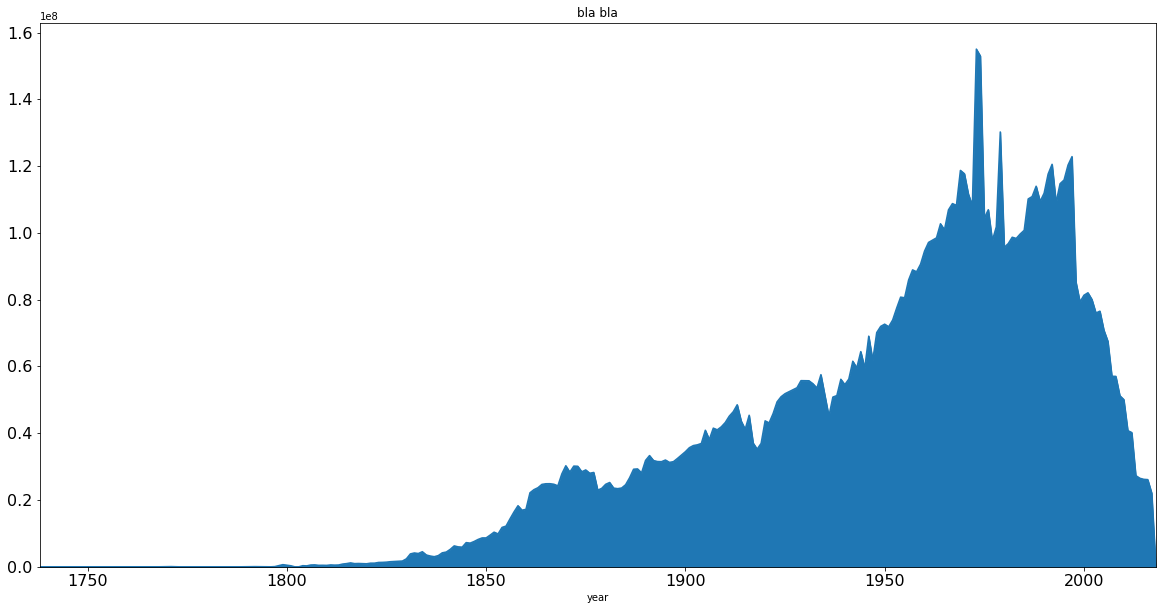

In [66]:
ax = df.n_tokens.plot(kind='area',  figsize=(20,10), fontsize=16,)

In [71]:
ax.ticklabel_format(style='plain')

In [72]:
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [75]:
ax.set_title('Number of tokens per year', size = 16)
ax.set_xlabel('Year', size = 16)

Text(0.5, 22.200000000000003, 'Year')

In [76]:
ax.get_figure().savefig('/home/romanell/Downloads/lrec_plot.png', dpi=300)

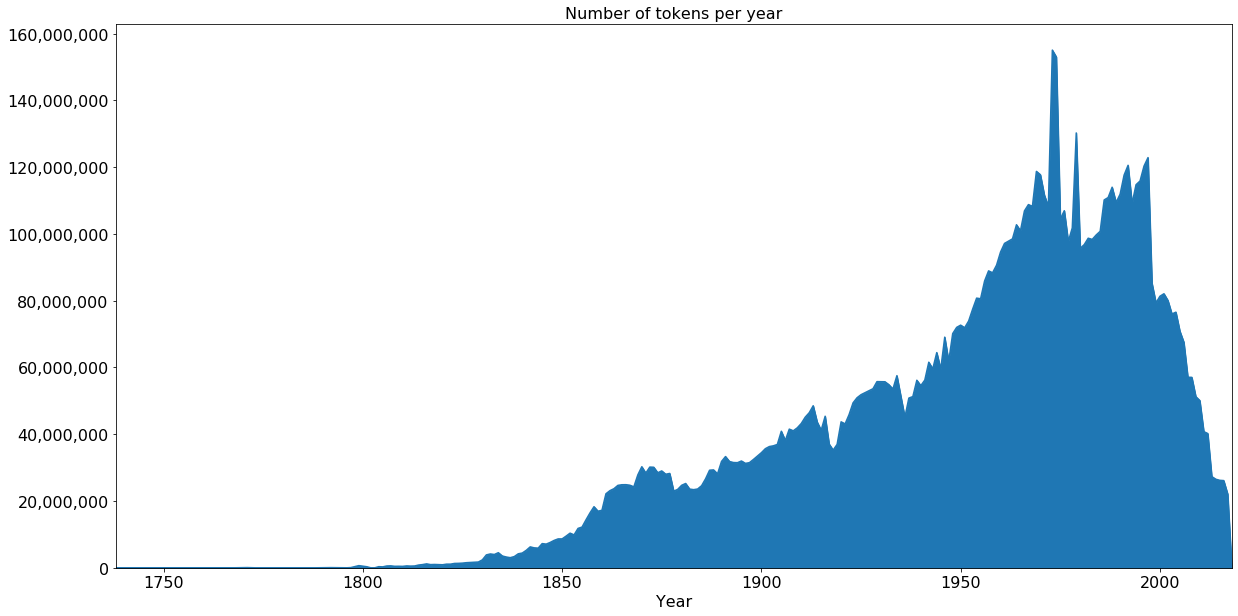

In [77]:
ax.get_figure()